In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
import numpy as np
import torch
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.example_functions import LogisticFunction
from src.optimizers import AGMsDR_2410_10800, AGMsDR_1809_05895, ACDM_our, ACDM, AGMsDR_3
from src.optimizers.Lobanov import CDM

In [3]:
n_dim = 100
scale = 1
torch.manual_seed(42)
func = LogisticFunction(n_dim=n_dim, scale=scale, seed=42, dtype=torch.float64)

x0 = torch.zeros(n_dim, dtype=torch.float64)
print(func.f(x0))  # tensor(0.6931)

max_iters = 4000

tensor(0.6931, dtype=torch.float64)


In [4]:
def simplified_stepsizes(x, f, grad_f, f_star, L0, L1):
    L1 = max(L1, 1e-12)
    L0 = max(L0, 1e-12)
    grad_norm = max(np.linalg.norm(grad_f(x)), 1e-12)
    nu = 1 / (L0 + 3 / 2 * L1 * grad_norm)
    return x - nu * grad_f(x)

In [5]:
def test_5(x0, func, nu, seed=None, max_iters=10000, verbose=False):
    if seed is not None:
        torch.manual_seed(seed)

    L0, L1 = func.l0l1_smooth

    agmsdr_optimizer = AGMsDR_3(x0=x0.clone(), f=func.f, T = simplified_stepsizes, grad_f=func.grad, L0=L0, L1=L1)
    f_history_agmsdr = torch.tensor(agmsdr_optimizer.AGMsDR(number_iter=max_iters, verbose=verbose, seed=seed))
    f_history_agmsdr = torch.cat([torch.tensor([func.f(x0)]), f_history_agmsdr])
    torch.save(f_history_agmsdr, 'results.pt')

    cdm = CDM(x=x0.clone(), f=func.f, grad_f=func.grad, L0=L0, L1=L1)
    f_history_cdm = torch.tensor(cdm.cycle(max_iters, verbose=verbose, seed=seed))
    f_history_cdm = torch.cat([torch.tensor([func.f(x0)]), f_history_cdm])
    torch.save(f_history_cdm, 'results2.pt')

    # Отображаем готовый график
    #visualizer.show()
    return f_history_agmsdr, f_history_cdm

In [6]:
loss_agmsdr, loss_cdm = test_5(x0=x0, func=func, nu=0.1, seed=42, max_iters=max_iters, verbose=True)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:00<00:00, 10222.84it/s]


In [7]:
def experiment(x0, function, optimizer, max_iters=1000, tol=1e-18, verbose=False):
    x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
    optimizer_instance = optimizer([x])

    loss_history = [function.f(x).item()]

    from src.optimizers.acdm import ACDM
    is_acdm = isinstance(optimizer_instance, ACDM) or isinstance(optimizer_instance, ACDM_our)
    
    def closure(backward=True):
        loss = function.f(x)
        # ACDM сам вызывает backward(), поэтому closure не должен это делать
        if backward and loss.requires_grad and not is_acdm:
            optimizer_instance.zero_grad()
            loss.backward()
        return loss
    
    loss_history.append(closure(backward=False).item())
    
    for i in tqdm(range(max_iters), desc="Iterations") if verbose else range(max_iters):
        loss = optimizer_instance.step(closure)
        if loss is None:
            loss = closure(backward=False)
        loss_history.append(loss.item())

    return x.detach().numpy(), np.array(loss_history)

In [8]:
L0, L1 = func.l0l1_smooth
L = float((1/4 * torch.linalg.norm(func.a) ** 2))
print(f"{L=}, {L0=}, {L1=}")

L=24.18023403660299, L0=0, L1=9.83468027677626


In [9]:
loss_history = {}
x_result = {}

In [10]:
from functools import partial


In [11]:
L_vec = func.a ** 2 / 4
acdm_optim = partial(ACDM, L=L_vec, alpha=0, sigma=0, dtype=torch.float64)
x_result['acc coord L-sm'], loss_history['acc coord L-sm'] = experiment(x0.clone(), func, acdm_optim, verbose=True, max_iters=max_iters)
print(loss_history['acc coord L-sm'][-1])

C:\Users\volan\AppData\Local\Temp\ipykernel_2968\3702354683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
Iterations:   0%|          | 0/4000 [00:00<?, ?it/s]c:\Users\volan\projects\sota_sirius\src\optimizers\acdm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_disc = torch.sqrt(torch.tensor(disc))
Iterations: 100%|██████████| 4000/4000 [00:01<00:00, 2005.56it/s]

6.341503870559239e-06


In [12]:
optim = partial(AGMsDR_1809_05895, L=L, dtype=torch.float64)
x_result['acc full L-sm'], loss_history['acc full L-sm'] = experiment(x0.clone(), func, optim, verbose=True, max_iters=max_iters)
print(loss_history['acc full L-sm'][-1])

C:\Users\volan\AppData\Local\Temp\ipykernel_2968\3702354683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
Iterations:   0%|          | 0/4000 [00:00<?, ?it/s]c:\Users\volan\projects\sota_sirius\src\optimizers\agmsdr.py:332: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss1 = float(closure(backward=False))
Iterations: 100%|██████████| 4000/4000 [00:16<00:00, 245.27it/s]

6.235048771639838e-08


In [13]:
# optim = partial(AGMsDR_1809_05895_Coordinate, L=L, dtype=torch.float64)
# x_result['acc coord L 2'], loss_history['acc coord L 2'] = experiment(x0.clone(), func, optim, verbose=True, max_iters=max_iters)
# print(loss_history['acc coord L 2'][-1])

In [14]:
optim = partial(AGMsDR_2410_10800, stepsize_type='simplified', L0=L0, L1=L1, dtype=torch.float64)
x_result['acc full L0-L1-sm'], loss_history['acc full L0-L1-sm'] = experiment(x0.clone(), func, optim, verbose=True, max_iters=max_iters)
print(loss_history['acc full L0-L1-sm'][-1])

C:\Users\volan\AppData\Local\Temp\ipykernel_2968\3702354683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
Iterations: 100%|██████████| 4000/4000 [00:15<00:00, 250.85it/s]

2.646105556888097e-12


In [15]:
L0_vec = torch.zeros(n_dim, dtype=torch.float64)
L1_vec = func.a ** 2

acdm_optim = partial(ACDM_our, l0=L0_vec, l1=L1_vec, alpha=0, dtype=torch.float64)
x_result['our'], loss_history['our'] = experiment(x0.clone(), func, acdm_optim, verbose=True, max_iters=max_iters)
print(loss_history['our'][-1])

C:\Users\volan\AppData\Local\Temp\ipykernel_2968\3702354683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
Iterations: 100%|██████████| 4000/4000 [00:01<00:00, 3027.34it/s]

0.0


In [16]:
loss_history['coord L0-L1-sm'] = loss_cdm # torch.load('../raw/results2.pt').detach().numpy()
loss_history['acc coord L0-L1-sm'] =  loss_agmsdr # torch.load('../raw/results.pt').detach().numpy()


In [17]:
keys = ['acc full L-sm', 'acc coord L-sm', 'coord L0-L1-sm', 'acc full L0-L1-sm', 'acc coord L0-L1-sm']

In [18]:
L_vec = func.a ** 2 / 4
acdm_optim = partial(ACDM, L=L_vec, alpha=0, sigma=0, dtype=torch.float64)
x_result['acc coord L-sm'], loss_history['acc coord L-sm'] = experiment(x0.clone(), func, acdm_optim, verbose=True, max_iters=max_iters)
print(loss_history['acc coord L-sm'][-1])

C:\Users\volan\AppData\Local\Temp\ipykernel_2968\3702354683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float64, requires_grad=True)
Iterations: 100%|██████████| 4000/4000 [00:01<00:00, 2005.39it/s]

6.341503870559239e-06


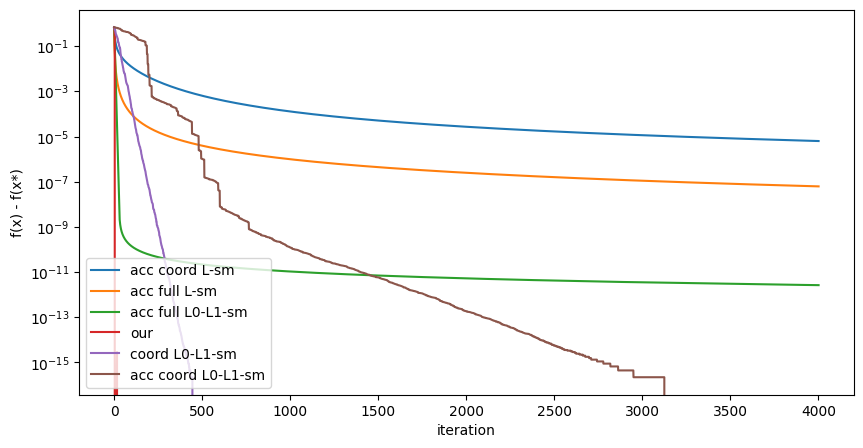

In [19]:
plt.figure(figsize=(10, 5))
for algo_name, l_history in loss_history.items():
    plt.plot(l_history, label=algo_name)



plt.yscale('log')
# plt.xscale('log')

plt.xlabel('iteration')
plt.ylabel('f(x) - f(x*)')
plt.legend()

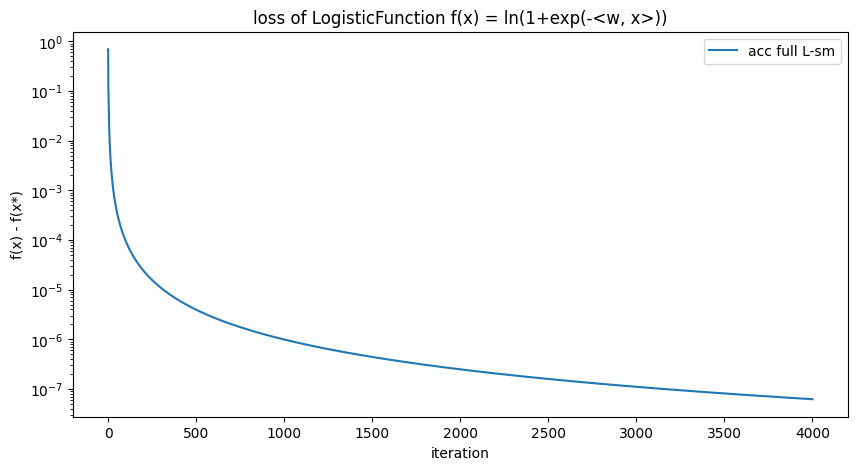

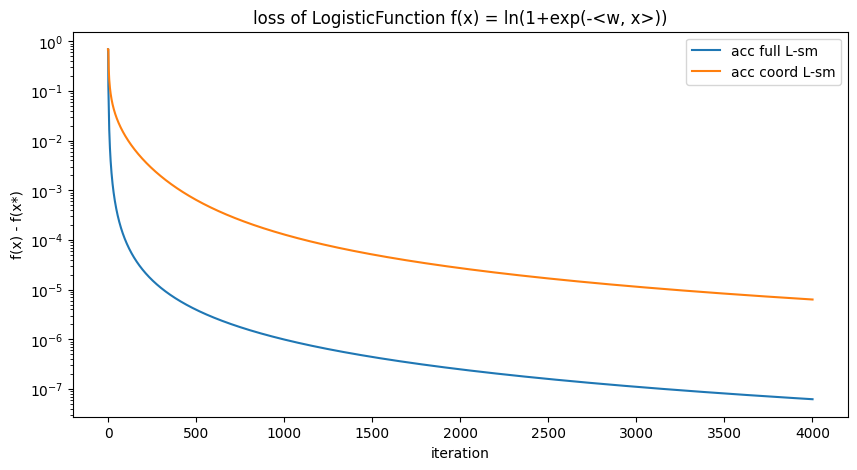

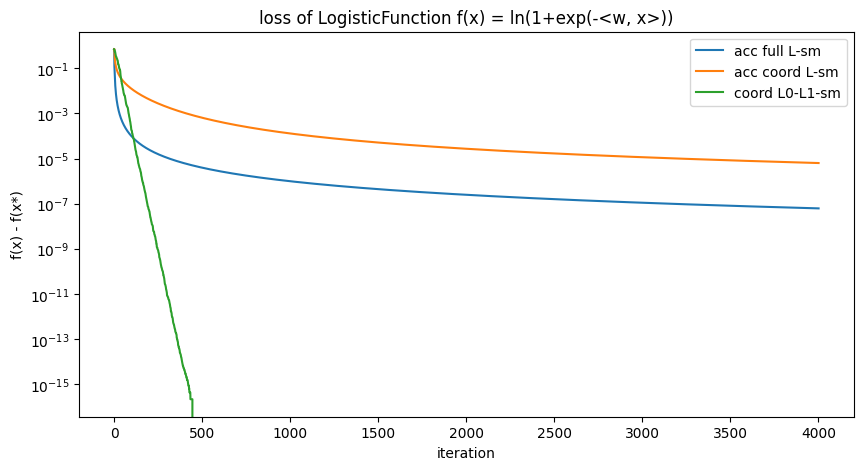

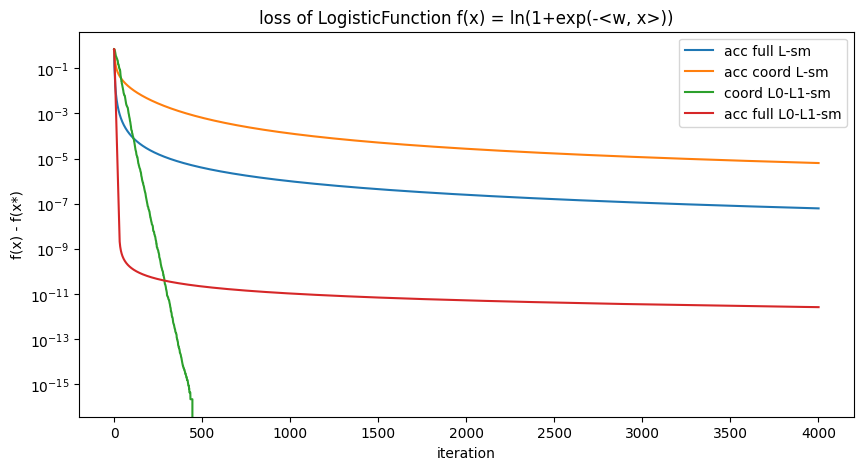

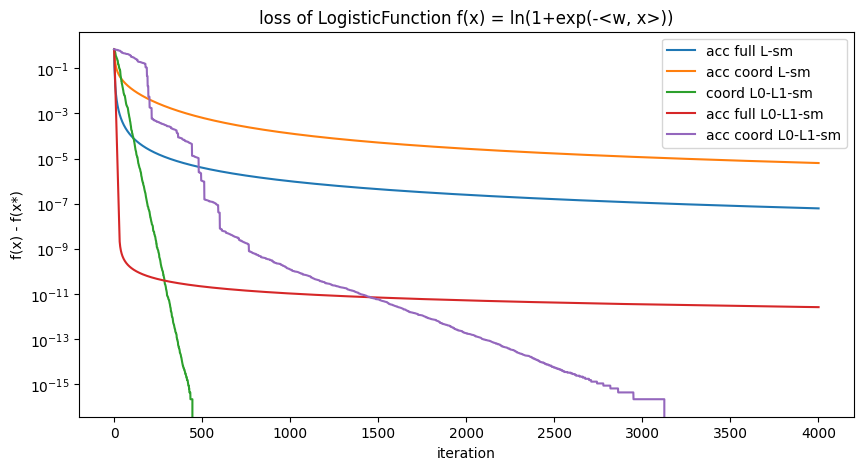

In [20]:
for i in range(1, len(keys) + 1):
    plt.figure(figsize=(10, 5))
    for algo_name in keys[:i]:
        plt.plot(loss_history[algo_name], label=algo_name)



    plt.yscale('log')
    # plt.xscale('log')

    plt.title('loss of LogisticFunction f(x) = ln(1+exp(-<w, x>))')
    plt.xlabel('iteration')
    plt.ylabel('f(x) - f(x*)')
    plt.legend()
    plt.show()